In [1]:
!pip install geopy
!pip install tqdm
!pip install BeautifulSoup4
!conda install -c conda-forge folium=0.5.0 --yes

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import json
from geopy.geocoders import Nominatim
from tqdm import tqdm
from geopy.extra.rate_limiter import RateLimiter
from math import sqrt, pi
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN 
from sklearn.cluster import KMeans 
import folium

%matplotlib inline

     |████████████████████████████████| 112kB 8.4MB/s eta 0:00:01
     |████████████████████████████████| 71kB 17.3MB/s eta 0:00:01
     |████████████████████████████████| 112kB 7.5MB/s eta 0:00:01
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    folium-0.5.0              

## Data acquisition from Wikipedia

In [2]:
# Importing data from Wikipedia
df_planning_areas = pd.read_html("http://en.wikipedia.org/wiki/Planning_Areas_of_Singapore", flavor='html5lib', header=0)[2]
df_planning_areas.head()

,Name (English),Malay,Chinese,Pinyin,Tamil,Region,Area (km2),Population[7],Density (/km2)
0,Ang Mo Kio,NaN,宏茂桥,Hóng mào qiáo,ஆங் மோ கியோ,North-East,13.94,163950,13400
1,Bedok,*,勿洛,Wù luò,பிடோக்,East,21.69,279380,13000
2,Bishan,NaN,碧山,Bì shān,பீஷான்,Central,7.62,88010,12000
3,Boon Lay,NaN,文礼,Wén lǐ,பூன் லே,West,8.23,30,3.6
4,Bukit Batok,*,武吉巴督,Wǔjí bā dū,புக்கிட் பாத்தோக்,West,11.13,153740,14000


In [3]:
# Dropping not-needed columns, renaming columns, and replacing empty values
df_planning_areas.drop(columns=["Malay", "Chinese", "Pinyin", "Tamil"], inplace = True)
df_planning_areas.columns = ["Planning Area", "Region", "Area", "Population", "Density"]
df_planning_areas.replace("*", 0, inplace=True)
df_planning_areas.head()

,Planning Area,Region,Area,Population,Density
0,Ang Mo Kio,North-East,13.94,163950,13400
1,Bedok,East,21.69,279380,13000
2,Bishan,Central,7.62,88010,12000
3,Boon Lay,West,8.23,30,3.6
4,Bukit Batok,West,11.13,153740,14000


In [4]:
df_planning_areas.dtypes

Planning Area     object
Region            object
Area             float64
Population        object
Density           object
dtype: object

In [5]:
# Correcting data types
df_planning_areas = df_planning_areas.astype({"Population":"float64", "Density":"float64"})
df_planning_areas.dtypes

Planning Area     object
Region            object
Area             float64
Population       float64
Density          float64
dtype: object

## Data acquisition using Nominatim geocoder

In [6]:
# Initialising geocoding agent
geolocator = Nominatim(user_agent="Mozilla/76.0")
location = geolocator.geocode("Singapore")
latitude = location.latitude
longitude = location.longitude
print(f"Coordinates of Singapore are {latitude}, {longitude}")

Coordinates of Singapore are 1.357107, 103.8194992


In [23]:
# Getting coordinates of each Planning Area, and adding suffix to search query
tqdm.pandas()
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
coords = (df_planning_areas["Planning Area"] + " suburb, Singapore").progress_apply(geocode)

100%|██████████| 55/55 [01:12<00:00,  1.33s/it]


In [27]:
# Adding two new empty columns to dataframe
df_planning_areas["Latitude"] = np.nan
df_planning_areas["Longitude"] = np.nan
df_planning_areas.head()

,Planning Area,Region,Area,Population,Density,Latitude,Longitude
0,Ang Mo Kio,North-East,13.94,163950.0,13400.0,NaN,NaN
1,Bedok,East,21.69,279380.0,13000.0,NaN,NaN
2,Bishan,Central,7.62,88010.0,12000.0,NaN,NaN
3,Boon Lay,West,8.23,30.0,3.6,NaN,NaN
4,Bukit Batok,West,11.13,153740.0,14000.0,NaN,NaN


In [28]:
# Populating the Latitude and Longitude columns with data from coords
for index in df_planning_areas.index:
    df_planning_areas.at[index, 'Latitude'] = coords[index].latitude
    df_planning_areas.at[index, 'Longitude'] = coords[index].longitude
    
df_planning_areas

,Planning Area,Region,Area,Population,Density,Latitude,Longitude
0,Ang Mo Kio,North-East,13.94,163950.0,13400.00,1.369842,103.846609
1,Bedok,East,21.69,279380.0,13000.00,1.325670,103.931471
2,Bishan,Central,7.62,88010.0,12000.00,1.351912,103.848971
3,Boon Lay,West,8.23,30.0,3.60,1.345640,103.711802
4,Bukit Batok,West,11.13,153740.0,14000.00,1.348283,103.749019
5,Bukit Merah,Central,14.34,151980.0,11000.00,1.270439,103.828318
6,Bukit Panjang,West,8.99,139280.0,15000.00,1.377921,103.771866
7,Bukit Timah,Central,17.53,77430.0,4400.00,1.329448,103.794166
8,Central Water Catchment,North,37.15,0.0,0.00,1.375708,103.801743
9,Changi,East,40.61,1830.0,80.62,1.351080,103.990064


In [29]:
# Adding a new Search Radius column into dataframe, and re-ordering columns
# The new Search Radius will be used in the Foursquare API search query
df_planning_areas["Search Radius"] = df_planning_areas["Area"].apply(lambda x: round(sqrt(x/pi)*1000))
df_planning_areas = df_planning_areas[['Planning Area', 'Region', 'Area', 'Search Radius', 'Population', 'Density', 'Latitude', 'Longitude']]

In [30]:
# Visualising map using folium
# for loop used to add map markers for each Planning Area
map_singapore = folium.Map(location = [latitude, longitude], zoom_start = 12)
for lat, lng, region, name in zip(df_planning_areas['Latitude'], df_planning_areas['Longitude'], df_planning_areas['Region'], df_planning_areas['Planning Area']):
    label = '{}, {}'.format(name, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore)

map_singapore

Most Planning Areas are correctly marked. However, the Boon Lay map marker is closely located to Jurong West.

In [31]:
# By running the geocoder again with the additional arugument exactly_one=False, 2 results are returned
boon_lay = geolocator.geocode(query="Boon Lay suburb, Singapore", exactly_one=False)
boon_lay

[Location(Boon Lay, Southwest, 640186, Singapore, (1.3456401, 103.7118018, 0.0)),
 Location(Boon Lay, Southwest, Singapore, (1.3136201500000002, 103.69882681209396, 0.0))]

In [32]:
# Determining which coordinates are currently stored in Boon Lay
df_planning_areas[df_planning_areas['Planning Area'] == 'Boon Lay']

,Planning Area,Region,Area,Search Radius,Population,Density,Latitude,Longitude
3,Boon Lay,West,8.23,1619,30.0,3.6,1.34564,103.711802


In [33]:
# Replacing the new Boon Lay coordinates into the dataframe
df_planning_areas.at[3, 'Latitude'] = boon_lay[1].latitude
df_planning_areas.at[3, 'Longitude'] = boon_lay[1].longitude
df_planning_areas[df_planning_areas['Planning Area'] == 'Boon Lay']

,Planning Area,Region,Area,Search Radius,Population,Density,Latitude,Longitude
3,Boon Lay,West,8.23,1619,30.0,3.6,1.31362,103.698827


In [34]:
# Visualising the map to verify changes were successfuly made
map_singapore = folium.Map(location = [df_planning_areas.loc[3, 'Latitude'], 
                                       df_planning_areas.loc[3, 'Longitude']], 
                            zoom_start = 13)
for lat, lng, region, name in zip(df_planning_areas['Latitude'], 
                                  df_planning_areas['Longitude'], 
                                  df_planning_areas['Region'], 
                                  df_planning_areas['Planning Area']):
    label = '{}, {}'.format(name, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore)

map_singapore

## Data acquisition from Foursquare

In [6]:
# Foursquare developer API credentials
CLIENT_ID = ''
CLIENT_SECRET = '' 
VERSION = '20180604'
LIMIT = 100

In [7]:
# Defining a function to get nearby venues, using the Foursquare API, and extracting relevant information from the JSON response
# The function returns nearby venues in that Planning Area
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radius):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Planning Area', 
                  'PA Latitude', 
                  'PA Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
# Calling the user-defined function, and saving the results into a variable
singapore_venues = getNearbyVenues(names=df_planning_areas['Planning Area'],
                                   latitudes=df_planning_areas['Latitude'],
                                   longitudes=df_planning_areas['Longitude'],
                                   radius=df_planning_areas['Search Radius']
                                  )

Ang Mo Kio
Bedok
Bishan
Boon Lay
Bukit Batok
Bukit Merah
Bukit Panjang
Bukit Timah
Central Water Catchment
Changi
Changi Bay
Choa Chu Kang
Clementi
Downtown Core
Geylang
Hougang
Jurong East
Jurong West
Kallang
Lim Chu Kang
Mandai
Marina East
Marina South
Marine Parade
Museum
Newton
North-Eastern Islands
Novena
Orchard
Outram
Pasir Ris
Paya Lebar
Pioneer
Punggol
Queenstown
River Valley
Rochor
Seletar
Sembawang
Sengkang
Serangoon
Simpang
Singapore River
Southern Islands
Straits View
Sungei Kadut
Tampines
Tanglin
Tengah
Toa Payoh
Tuas
Western Islands
Western Water Catchment
Woodlands
Yishun


In [23]:
print(singapore_venues.shape)
singapore_venues.head()

(3749, 7)


,Planning Area,PA Latitude,PA Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ang Mo Kio,1.369842,103.846609,Bishan - Ang Mo Kio Park,1.362219,103.846250,Park
1,Ang Mo Kio,1.369842,103.846609,Aramsa ~ The Garden Spa,1.362292,103.847602,Spa
2,Ang Mo Kio,1.369842,103.846609,Face Ban Mian 非板面 (Ang Mo Kio),1.372031,103.847504,Noodle House
3,Ang Mo Kio,1.369842,103.846609,Old Chang Kee,1.369094,103.848389,Snack Place
4,Ang Mo Kio,1.369842,103.846609,FairPrice Xtra,1.369279,103.848886,Supermarket


In [21]:
print("Number of unique venue categories in Singapore planning areas:{}".format(len(singapore_venues["Venue Category"].unique())))

Number of unique venue categories in Singapore planning areas:324


In [9]:
# Dropping duplicated venues from the dataframe
venues_deduplicated = singapore_venues.drop_duplicates(subset='Venue')
print('Number of duplicated venues removed {}'.format(singapore_venues.shape[0]-venues_deduplicated.shape[0]))

Number of duplicated venues removed 1014


In [10]:
# one hot encoding
singapore_onehot = pd.get_dummies(venues_deduplicated[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
singapore_onehot.insert(loc = 0, column = 'Planning Area', value = venues_deduplicated['Planning Area'])

# summing one-hot values
singapore_grouped_sum = singapore_onehot.groupby('Planning Area').sum().reset_index()
singapore_grouped_sum.head()

,Planning Area,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Bedok,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Bishan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Boon Lay,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
4,Bukit Batok,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data exploration

In [73]:
# Showing the top 5 venue categories for each Planning Area
num_top_venues = 5

for area in singapore_grouped_sum['Planning Area']:
    print("----"+area+"----")
    temp = singapore_grouped_sum[singapore_grouped_sum['Planning Area'] == area].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ang Mo Kio----
                 venue  freq
0           Food Court  17.0
1   Chinese Restaurant  11.0
2          Coffee Shop   6.0
3                 Park   4.0
4  Japanese Restaurant   3.0


----Bedok----
                venue  freq
0  Chinese Restaurant  11.0
1          Food Court   8.0
2  Seafood Restaurant   5.0
3         Coffee Shop   5.0
4                Café   4.0


----Bishan----
                venue  freq
0  Chinese Restaurant  10.0
1          Food Court   8.0
2  Seafood Restaurant   5.0
3        Noodle House   4.0
4                Café   3.0


----Boon Lay----
            venue  freq
0         Exhibit   4.0
1     Zoo Exhibit   2.0
2            Café   2.0
3    Fishing Spot   2.0
4  Scenic Lookout   2.0


----Bukit Batok----
                venue  freq
0  Chinese Restaurant  10.0
1         Coffee Shop   9.0
2          Food Court   8.0
3                Café   4.0
4    Department Store   3.0


----Bukit Merah----
                          venue  freq
0  Theme Park Ride / Attr

In [7]:
# Getting the top 10 venue categories in all Planning Areas combined
venue_count = venues_deduplicated[['Planning Area', 'Venue Category']].groupby('Venue Category').count()
venue_top10 = venue_count.sort_values(by='Planning Area', ascending=False).rename(columns={'Planning Area':'Count'}).head(10)
venue_top10.reset_index(drop=False, inplace=True)
venue_top10

,Venue Category,Count
0,Chinese Restaurant,167
1,Food Court,166
2,Café,110
3,Coffee Shop,110
4,Asian Restaurant,96
5,Hotel,79
6,Japanese Restaurant,71
7,Park,65
8,Indian Restaurant,60
9,Bakery,59


Top 10 venue categories returned by the Foursquare API in all Planning Areas throughout Singapore, sorted in descending order.

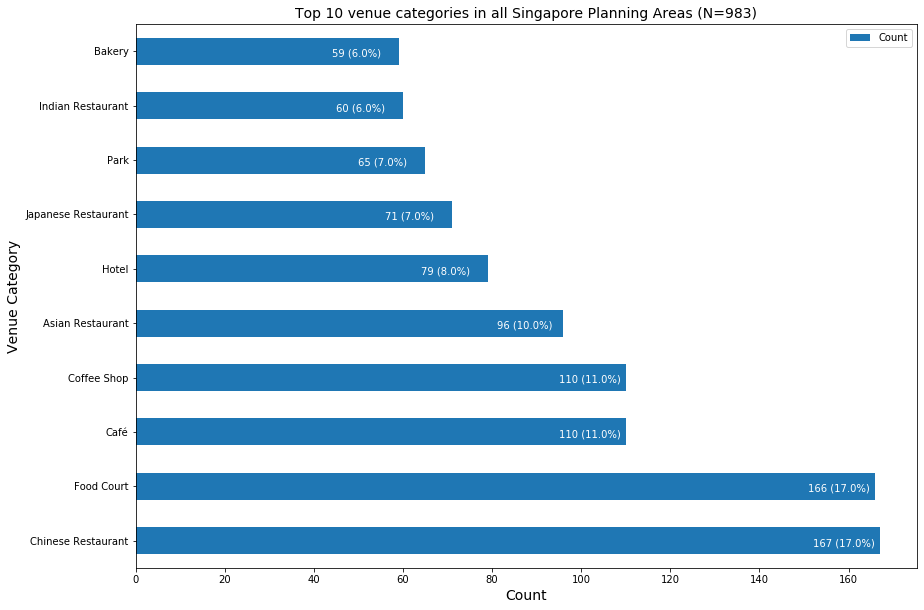

In [8]:
# Plotting bar chart
venue_top10.plot(kind='barh', x='Venue Category', y='Count', figsize=(14,10))
plt.xlabel('Count', fontsize=14)
plt.ylabel('Venue Category', fontsize=14)
plt.title(f'Top 10 venue categories in all Singapore Planning Areas (N={venue_top10.Count.sum()})', fontsize=14)

for index, count in zip (venue_top10.index, venue_top10.Count):
    plt.annotate(f'{count} ({round(count/venue_top10.Count.sum()*100)}%)', xy=(count - 15, index-0.1), color="white")

plt.show()

It is noted that 8 out of 10 categories are food-related categories, while the remaining two are Hotel and Park. It can be concluded that the top businesses in all Planning Areas combined in Singapore are food-related.

In [11]:
# Calculating pearson correlations of all venue categories with density
correlation = singapore_grouped_sum.corrwith(df_planning_areas["Density"], method='pearson')
correlation.sort_values(ascending=False, inplace=True)
print(f'Pearson correlation of top 5 venue categories with population density: \n{correlation[:5]} \n')
print(f'Pearson correlation of bottom 5 venue categories with population density: \n{correlation[-5:]}')

Pearson correlation of top 5 venue categories with population density: 
Food Court            0.641849
Coffee Shop           0.532433
Pool                  0.521503
Chinese Restaurant    0.472719
Market                0.448904
dtype: float64 

Pearson correlation of bottom 5 venue categories with population density: 
Airport           -0.218587
Theater           -0.232275
Harbor / Marina   -0.274835
Boat or Ferry     -0.289389
Smoke Shop        -0.323860
dtype: float64


The Pearson correlations above show that food courts, coffee shops, pools, Chinese restaurants, and markets have a moderately positive relationship with population density. While smoke shops, boat or ferry, harbor/marina, theaters and airports have a weak negative relationship with population density.

In [12]:
# Filtering the variable of interest for further analysis
food_court = singapore_grouped_sum[['Planning Area', 'Food Court']]
food_court.insert(loc=1, column='Density', value=df_planning_areas['Density'])
food_court.rename(columns={'Food Court':'Count'}, inplace=True)
food_court.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Planning Area,Density,Count
0,Ang Mo Kio,13400.0,17
1,Bedok,13000.0,8
2,Bishan,12000.0,8
3,Boon Lay,3.6,1
4,Bukit Batok,14000.0,8


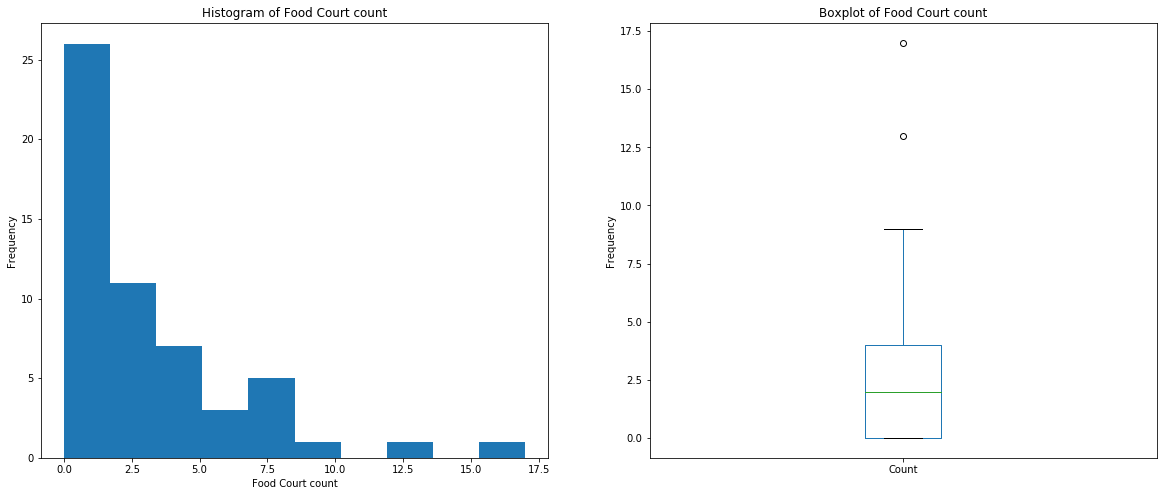

In [17]:
# Visualising the distribution of Food Court count
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)

# Subplot 1: Histogram
food_court['Count'].plot(kind='hist', title='Histogram of Food Court count', figsize=(20,8), ax=ax0)
ax0.set_xlabel('Food Court count')

# Subplot 2: Boxplot
food_court['Count'].plot(kind='box', title='Boxplot of Food Court count', figsize=(20,8), ax=ax1)
ax1.set_ylabel('Frequency')

plt.show()

Food Court count data are right skewed and need to be standardised prior to further analysis.

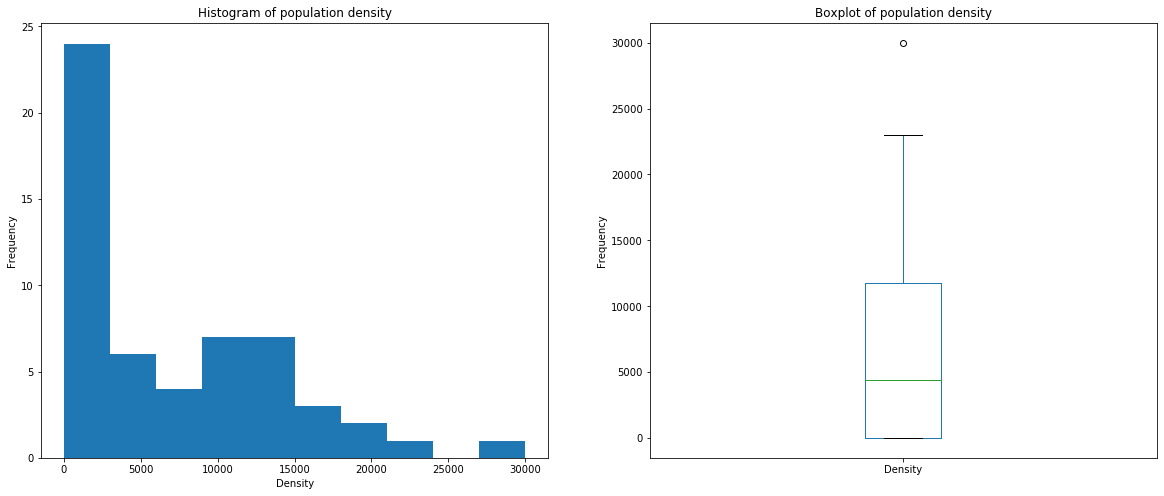

In [19]:
# Visualising the distribution of Density
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)

# Subplot 1: Histogram
food_court['Density'].plot(kind='hist', title='Histogram of population density', figsize=(20, 8), ax=ax0)
ax0.set_xlabel('Density')

# Subplot 2: Boxplot
food_court['Density'].plot(kind='box', title='Boxplot of population density', figsize=(20,8), ax=ax1)
ax1.set_ylabel('Frequency')

plt.show()

Population density data are right skewed and need to be standardised prior to further analysis.

## Data standardisation

In [13]:
scaler = StandardScaler()
fc_scaled = scaler.fit_transform(food_court[['Density', 'Count']])
fc_scaled_df = pd.DataFrame(fc_scaled, columns=['Density_norm', 'Count_norm'])

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


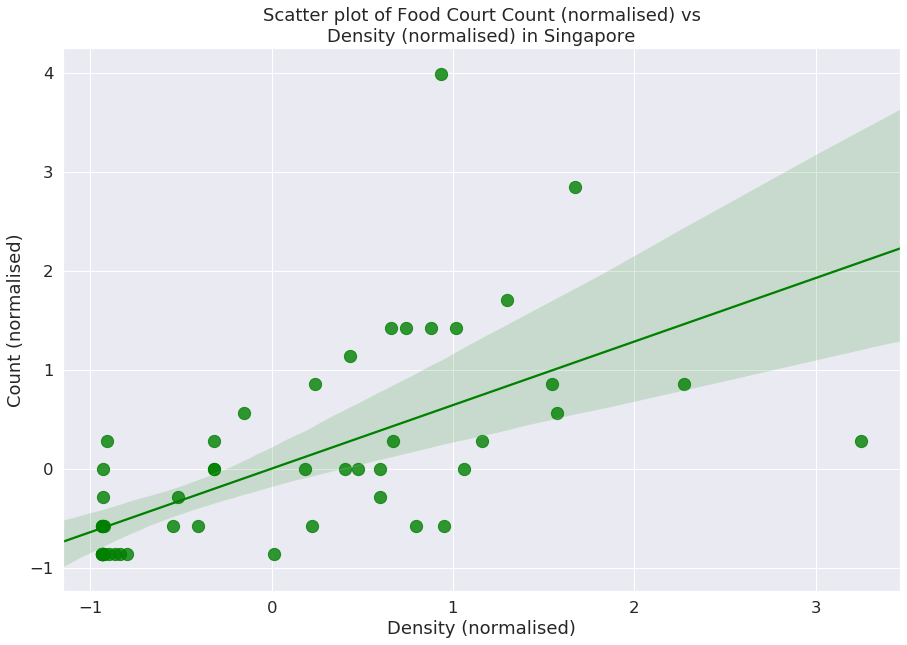

In [25]:
# Plotting scatter plot between Food Court count and Density
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.5)
sns.regplot(x='Density_norm', y='Count_norm', data=fc_scaled_df, color='green', scatter_kws={'s': 150})
plt.xlabel('Density (normalised)')
plt.ylabel('Count (normalised)')
plt.title('Scatter plot of Food Court Count (normalised) vs\nDensity (normalised) in Singapore')
sns.set_style('ticks')
plt.show()

As the population density increases, the Food Court number increases. This shows a moderately positive relationship between the two variables.

## Clustering data using Machine Learning

### DBSCAN clustering algorithm

In [19]:
db = DBSCAN(eps=0.35, min_samples=3).fit(fc_scaled)
labels = db.labels_

# First, create an array of booleans using the labels from db.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Remove repetition in labels by turning it into a set.
unique_labels = set(labels)

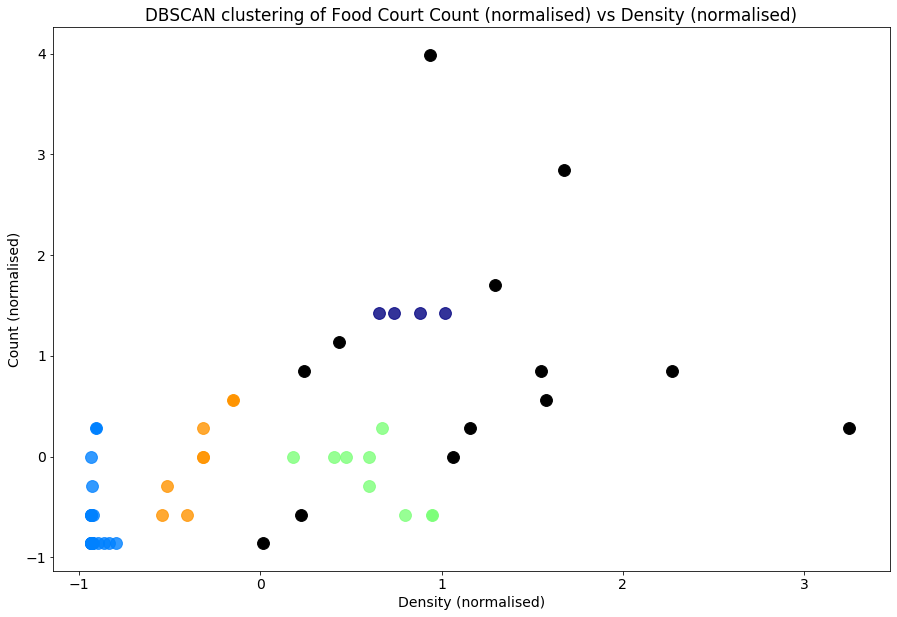

In [18]:
# Create colors for the clusters.
colours = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

fig = plt.figure(figsize=(15,10))
# Plot the points with colors
for k, col in zip(unique_labels, colours):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    # Plot the datapoints that are clustered
    xy = fc_scaled[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=140, c=[col], marker=u'o', alpha=0.8)

    # Plot the outliers
    xy = fc_scaled[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=140, c=[col], marker=u'o', alpha=1)

plt.rcParams.update({'font.size': 14})
plt.xlabel('Density (normalised)', fontsize=14)
plt.ylabel('Count (normalised)', fontsize=14)
plt.title('DBSCAN clustering of Food Court Count (normalised) vs Density (normalised)')
plt.show()

The DBSCAN algorithm generated 4 clusters (highlighted by the blue, orange, light green, and purple dots), while highlighting the remaining dots as outliers. While the coloured dots are appropriately clustered based on density, too much information (13 points of data) has been left out and labelled as outliers. A different clustering algorithm needs to be considered to cluster the above data.

### K-Means clustering algorithm

In [14]:
# run k-means clustering
k_means = KMeans(n_clusters=4, random_state=0, n_init=12).fit(fc_scaled)

# saving the labels and cluster centers into variables
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

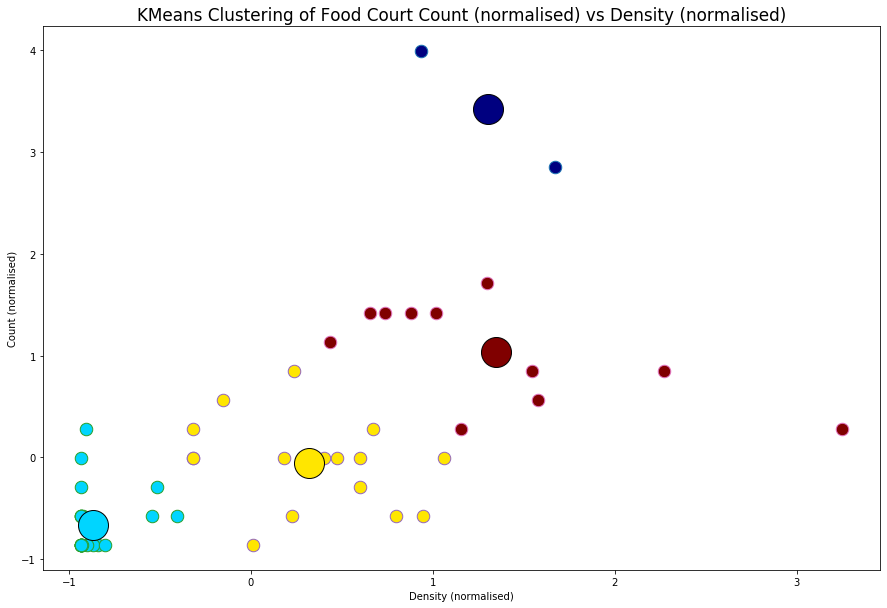

In [15]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(15,10))

# Colours uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colours = plt.cm.jet(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# Setting font size
plt.rcParams.update({'font.size': 14})

# For loop that plots the data points and centroids.
for k, col in zip(range(len(k_means_cluster_centers)), colours):

    # Create a list of all data points, where the data poitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(fc_scaled[my_members, 0], fc_scaled[my_members, 1], 'o', markerfacecolor=col, marker='.', markersize=25)
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=30)

ax.set_title('KMeans Clustering of Food Court Count (normalised) vs Density (normalised)')
ax.set_xlabel('Density (normalised)')
ax.set_ylabel('Count (normalised)')
plt.show()

Cluster 0: dark blue circles, Cluster 1: light blue circles, Cluster 2: yellow circles, Cluster 3: maroon circles. Large circles represent centroids of their respective clusters.

All data points are given cluster labels, including outliers. The K-Means clustering algorithm generates better clustering than DBSCAN clustering algorithm.

In [16]:
# Creating a new dataframe with necessary columns and adding cluster labels generated from K-Means algorithm
fc_merged = pd.merge(food_court, 
                     df_planning_areas[['Planning Area', 'Latitude', 'Longitude']], 
                     how='left', 
                     on='Planning Area')
fc_merged.insert(loc=(len(fc_merged.columns)), column='Cluster Label', value=k_means_labels)
fc_merged.head()

,Planning Area,Density,Count,Latitude,Longitude,Cluster Label
0,Ang Mo Kio,13400.0,17,1.369842,103.846609,0
1,Bedok,13000.0,8,1.325670,103.931471,3
2,Bishan,12000.0,8,1.351912,103.848971,3
3,Boon Lay,3.6,1,1.313620,103.698827,1
4,Bukit Batok,14000.0,8,1.348283,103.749019,3


In [17]:
# Summary of cluster labels
fc_merged['Cluster Label'].value_counts()

1    26
2    16
3    11
0     2
Name: Cluster Label, dtype: int64

## Results

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(len(set(labels)))
ys = [i + x + (i*x)**2 for i in range(len(set(labels)))]
colors_array = cm.jet(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(fc_merged['Latitude'], fc_merged['Longitude'], fc_merged['Planning Area'], \
                                  fc_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

## Analysing individual clusters

In [288]:
cluster0 = fc_merged[fc_merged['Cluster Label'] == 0].drop(columns=['Latitude', 'Longitude'])
print('Cluster 0 (n={}) are areas with high numbers of Food Courts per Planning Area (range: {} - {})\n\
with moderate Population Denisty (median density={})'.format(cluster0.count()[0], 
                                                           cluster0['Count'].min(),
                                                           cluster0['Count'].max(),
                                                           cluster0['Density'].median()))
cluster0.sort_values(by='Count', ascending=False)

Cluster 0 (n=2) are areas with high numbers of Food Courts per Planning Area (range: 13 - 17)
with moderate Population Denisty (median density=16050.0)


,Planning Area,Density,Count,Cluster Label
0,Ang Mo Kio,13400.0,17,0
53,Woodlands,18700.0,13,0


In [289]:
cluster1 = fc_merged[fc_merged['Cluster Label'] == 1].drop(columns=['Latitude', 'Longitude'])
print('Cluster 1 (n={}) are places with low numbers of Food Courts per Planning Area (range: {} - {})\n\
with low Population Denisty (median density={})'.format(cluster1.count()[0],  
                                                        cluster1['Count'].min(), 
                                                        cluster1['Count'].max(),  
                                                        cluster1['Density'].median()))
cluster1.sort_values(by='Count', ascending=False)

Cluster 1 (n=26) are places with low numbers of Food Courts per Planning Area (range: 0 - 4)
with low Population Denisty (median density=6.75)


,Planning Area,Density,Count,Cluster Label
20,Mandai,180.20,4,1
50,Tuas,2.30,3,1
42,Singapore River,3000.00,2,1
32,Pioneer,8.30,2,1
3,Boon Lay,3.60,1,1
9,Changi,80.62,1,1
51,Western Islands,0.25,1,1
48,Tengah,1.40,1,1
21,Marina East,0.00,1,1
47,Tanglin,2800.00,1,1


In [290]:
cluster2 = fc_merged[fc_merged['Cluster Label'] == 2].drop(columns=['Latitude', 'Longitude'])
print('Cluster 2 (n={}) are areas with low numbers of Food Courts per Planning Area (range: {} - {})\n\
with low-moderate Population Denisty (median density={})'.format(cluster2.count()[0],  
                                                                 cluster2['Count'].min(), 
                                                                 cluster2['Count'].max(), 
                                                                 cluster2['Density'].median()))
cluster2.sort_values(by='Count', ascending=False)

Cluster 2 (n=16) are areas with low numbers of Food Courts per Planning Area (range: 0 - 6)
with low-moderate Population Denisty (median density=9000.0)


,Planning Area,Density,Count,Cluster Label
38,Sembawang,8400.0,6,2
27,Novena,5600.0,5,2
16,Jurong East,4400.0,4,2
40,Serangoon,11500.0,4,2
7,Bukit Timah,4400.0,3,2
18,Kallang,11000.0,3,2
23,Marine Parade,8000.0,3,2
30,Pasir Ris,9600.0,3,2
34,Queenstown,4400.0,3,2
49,Toa Payoh,14300.0,3,2


In [18]:
cluster3 = fc_merged[fc_merged['Cluster Label'] == 3].drop(columns=['Latitude', 'Longitude'])
print('Cluster 3 (n={}) are areas with medium number of Food Courts per Planning Area (range: {} - {})\n\
with moderate Population Denisty (median density={})'.format(cluster3.count()[0],  
                                                             cluster3['Count'].min(), 
                                                             cluster3['Count'].max(), 
                                                             cluster3['Density'].median()))
cluster3.sort_values(by='Count', ascending=False)

Cluster 3 (n=11) are areas with medium number of Food Courts per Planning Area (range: 4 - 9)
with moderate Population Denisty (median density=15000.0)


,Planning Area,Density,Count,Cluster Label
15,Hougang,16000.0,9,3
1,Bedok,13000.0,8,3
2,Bishan,12000.0,8,3
4,Bukit Batok,14000.0,8,3
14,Geylang,11400.0,8,3
12,Clementi,9800.0,7,3
33,Punggol,17800.0,6,3
39,Sengkang,23000.0,6,3
17,Jurong West,18000.0,5,3
6,Bukit Panjang,15000.0,4,3


In [19]:
# Getting the Planning Areas with highest densities in Cluster 3, sorted by density in descending order
cluster3.sort_values(by='Density', ascending=False).head(2)

,Planning Area,Density,Count,Cluster Label
11,Choa Chu Kang,30000.0,4,3
39,Sengkang,23000.0,6,3
